# Linear Models
In any problem, it is often useful to start by attempting the 'simplest possible solution' first. In machine learning, this is often the linear model. Linear models for prediction could be fitted by least-squares, e.g. predictive least squares (PLS), or by hypothesis of an explicit data generating process, e.g. autoregressive moving-average (ARMA) models. Our model will have the form

$$
y(t+1) = \sum_{\ell=0}^L \left( a_\ell y(t-\ell) + b_\ell^1 x_1(t-\ell) + \cdots + b_\ell^P x_P (t-\ell) \right) + \varepsilon(t)
$$

where $y$ is our target variable, $x_1,...,x_P$ are the $P$ additional predictor variables in our dataset and $\varepsilon(t)$ are random perturbations to the system.

In this module, I will consider autoregressive models with exogenous inputs (ARX) applied to the natural gas dataset. The first model will use stocks and airport temputers as exogenous variables, while the second model will additionally incorporate the heating/cooling forecasts.


In [1]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.signal import savgol_filter
from numpy import linalg as lin
import seaborn as sns
import pandas as pd

# Import data
my_data = genfromtxt('../Data/natgas.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,1:] # Ignore the first row, which contains headers
names = ["STOCKS","HDD_FORE","CDD_FORE","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]


## Relevant Concepts
### Principal Component Analysis
When using any high-dimensional model, having many correlated features can impair the performance of the method. In the case of a linear model, if many features are linearlty dependent, then functions that treat all features at once could be accumlating unnecessary noise by adding terms from each feature. Thus, linear dimensionality reduction is often useful to improve the performance of linear models, and in this section we use principal component analysis (PCA).

Consider a dataset of samples from a multivariate Gaussian distribution. To fit a Gaussian distribution to the data, we need to find the mean vector and covariance matrix of the data. The mean can be computed in the usual way using sample means, but computation of the covariance matrix requires us to find the directions of correlations in the data set. The level sets of a Gaussian are ellipsoids, and the principal axes of the ellipsoids correspond to vectors of uncorrelated components that may provide an alternative basis for our random vectors. PCA is a method that allows us to compute these uncorrelated components, and to orthogonally project our data onto the first $k$ components that have the most significant variance in the joint distribution.

Many implementations of PCA will use the singular value decomposition (SVD), e.g. *scikit-learn*. The following derivation is from Brunton & Kutz (2017). Given a matrix $X$ whose $N$ rows are samples from our multivariate distribution, which we assume has zero-mean. The covariance matrix $C$ is given by
$$
C = \frac{1}{N-1} X^\top X
$$
The SVD of the covariance matrix may then be produced
$$
C = Q\Sigma Q^\top 
$$
since $C$ is a real symmetric positive-definite matrix. Up to sign change, the matrix $Q$ produces the orthonomal principal component basis, and the order of the singular values $\Sigma$ corresponds to the order of the eigenvaleus of the covariance matrix.

### Delay Coordinate Map
To fit an autoregressive model, we need to produce input-output pairs that will be the training data in our model. For an AR($Q$) model, we need to produce delay vectors of the form 
$$
\begin{bmatrix} y(n-1) & y(n-2) & \cdots & y(n-Q) \end{bmatrix}
$$
for each $n= Q+1, ..., N$. For a vector of features $\begin{bmatrix} y(1) & \cdots & y(N) \end{bmatrix}^\top$, we produce the matrix of all possible delay vectors by the $\text{embed}$ map:
$$
\text{embed}\left(\,\begin{bmatrix} y(1) \\ \cdots \\ y(N) \end{bmatrix}\,\right) :=
\begin{bmatrix}
y(1) & \cdots & y(Q) \\
\vdots & & \vdots \\
y(n-Q+1) & \cdots & y(n) \\
\vdots & & \vdots \\
y(N-Q+1) & \cdots & y(N)
\end{bmatrix}
$$
We may implement the embed map with a Python function:

In [2]:
def embed(x,Q,tau):
    """
    This is a simple delay embedding function. 
    
    :param x: is the input time series, arranged as a Nx1 colummn matrix (numpy array)
    :param Q: is the dimension of the desired delay coordinate matrix
    :param tau: is the time delay between entries, if needed
    :returns: The delay embedding matrix X
    """
    N = x.shape[0]
    X = np.empty((N-(Q-1)*tau,Q))
    for q in range(0,Q):
        X[:,q] = x[np.arange(0,N-(Q-1)*tau)+q*tau]
    return X

In practice, the embed map allows us to organize data to train AR and ARX models easily. We note that the embed map is also commonly used in dynamical systems theory and neuroscience, where the delay embedding map plays an important role in the reconstruction of unobserved latent state space models.

## ARX Model 1
Here, we fit our first ARX model that uses stocks and airport temperatures to forecast the changes in the level of natural gas stocks. We use deseasonalization and PCA as previously noted, but for this model, we ignore the HDD/CDD features, since these are no available for the entirety of the observation window.

For now, I'm taking the order of the model, 3, and later this week I will do something better. We will use the first 600 datapoints to fit the model, and we'll visualize our fit in-sample in this section.

In [3]:
# Delete the unused features
X = my_data[0:600,:]
X = np.delete(X,1,axis=1)
X = np.delete(X,1,axis=1)
Xnames = ["STOCKS","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]

# Deseasonalize the data
window_length = 13
polyorder = 2
datatrend = savgol_filter(X[:,4:10], window_length, polyorder, axis=0)
X[:,4:10] = X[:,4:10] - datatrend

# For now, take the model length as a given
Q = 3

# Delay embed all of our data. The last column will be our target
Z = np.empty((X.shape[0]-Q+1,Q*X.shape[1]))
for k in range(0,X.shape[1]):
    Z[:,np.arange(0,Q) + k*Q] = embed(X[:,k],Q,1)

# Remove separate target and predictors
y = Z[:,Z.shape[1]-1]  
Z = Z[:,0:Z.shape[1]-1]

# Normalize the input predictors
Z = normalize(Z, axis=0)

Now that we have the input-output pairs for our model (in the objects `Z` and `y` respectively), we can consider PCA and fitting the model. At this point, it is instructive to visualize the correlation matrix on the delay embedding data before and after PCA.

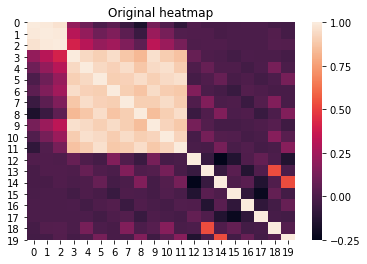

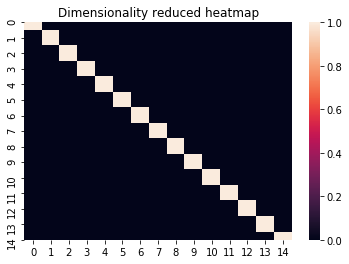

In [4]:
# Original heatmap
plt.figure()
my_frame = pd.DataFrame(Z)
sns.heatmap(my_frame.corr())
plt.title('Original heatmap')
plt.show()

# Perform PCA
pca = PCA(n_components=15)
Z = pca.fit_transform(Z)

# Dimensionality reduced heatmap
plt.figure()
my_frame = pd.DataFrame(Z)
sns.heatmap(my_frame.corr())
plt.title('Dimensionality reduced heatmap')
plt.show()


We observe that the dimensionality reduced heatmap is diagonal, which indicates that our PCA successfully produced uncorrelated components.

Next, we need to fit a linear model to the data. For now, I'm just going to use a least squares fit.

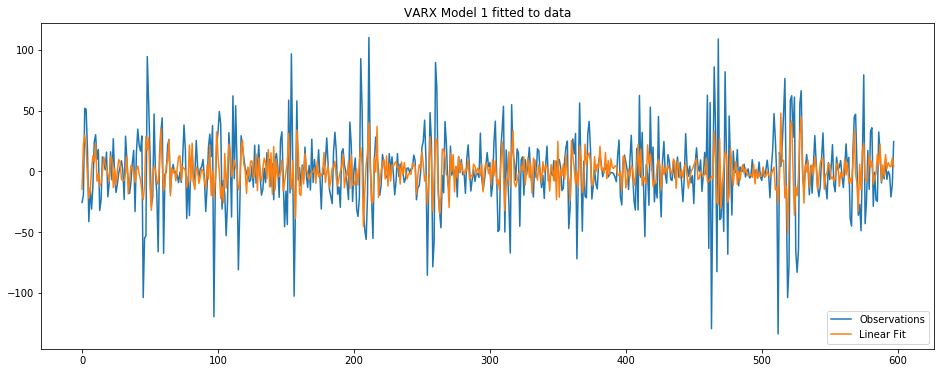

In [5]:
# Fit a linear model using least squares
linmdl = np.linalg.lstsq(Z, y, rcond=None)
yp = Z @ linmdl[0] 

# Let's plot the predictions and the results
t = np.transpose(np.arange(0,y.shape[0]))
plt.figure(figsize=(16, 6))
plt.plot(t,y,t,yp)
plt.legend(['Observations','Linear Fit'], loc='lower right')
plt.title('VARX Model 1 fitted to data')
plt.show()

The plot shows that the linear model predictions and the actual predictions don't quite coincide, but they have several reassuring features.

- The periods of low variance coincide with the period of low variance in our predictions. Likewise for higher variance areas.
- Some regions between bursts of oscillations appear to fit better.

Another way to visualize how this model is doing is to use an observation-vs-prediction plot, shown below. We see that in this case, the prediction and observation are clustered on the line $y=x$, indicated that the linear model is working to some degree, but the scatterplot still shows a high variance about this line, which indicates that we have a lot of room for improvement.

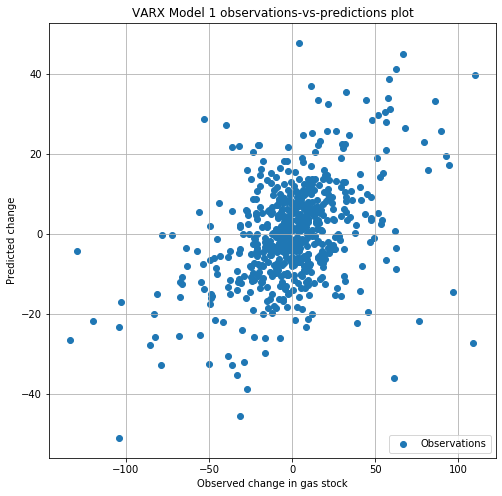

In [6]:
# Scatterplot results
plt.figure(figsize=(8, 8))
plt.scatter(y,yp)
plt.grid('on')
plt.legend(['Observations','Linear Fit'], loc='lower right')
plt.title('VARX Model 1 observations-vs-predictions plot')
plt.xlabel('Observed change in gas stock')
plt.ylabel('Predicted change')
plt.show()

## VARX Model 2
Here, we fit our second VARX model that extends the first model by including the two additional predictors (heating/cooling forecasts).


We need to impute a few missing data points, but we do not bother ourselves with extrapolating the model into the times before HDD/CDD forecasts were observed.

## Comparison of VARX Models
We will do more rigourous discussion to compare models in the last notebook, but for now we can make some simple observations about these results.